### jupyter notebook dfr the exploratory data analysis of the onet data enriched with historical data from Osborne & Frey

author: Jan Jörg
date: 14.03.2024

In [1222]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import json
import plotly.graph_objects as go
from itertools import chain
from db import get_database
from sklearn.metrics import * 
from sklearn.utils import resample
from matplotlib import rcParams
import statsmodels.api as sm
import pylab as py
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

In [1223]:
dbname = get_database()
df_col = dbname["fo_with_id"]
education = dbname["education"]
job_zone = dbname["job_zone"]
abilities = dbname["abilities"]
skills = dbname["skills"]

education =  pd.DataFrame(list(education.find()))
job_zone = pd.DataFrame(list(job_zone.find()))
df = pd.DataFrame(list(df_col.find()))
abilities = pd.DataFrame(list(abilities.find()))
skills = pd.DataFrame(list(skills.find())) 

print(df.shape[0])
df.head(5)

326


,_id,job_zone,education,isco08,Name_de,Berufshauptgruppe,s10,s1,s4,s11,...,a36,a39,a41,a43,a44,a28,a40,a49,fo_probability,fo_computerisation
0,663e2380db2fdc9e602a95af,1,1,2655,Schauspieler,2,47,72,69,47,...,22,3,0,0,0,25,3,0,0.370,na
1,663e2380db2fdc9e602a95bc,4,9,2612,Richter,2,78,81,72,78,...,0,28,16,0,31,22,6,0,0.400,na
2,663e2380db2fdc9e602a9582,3,8,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3,56,69,47,53,...,19,50,53,0,50,50,25,19,0.240,na
3,663e2380db2fdc9e602a9516,2,2,2120,"Mathematiker, Aktuare und Statistiker",2,81,81,50,63,...,0,78,0,0,91,13,13,0,0.035,na
4,663e2380db2fdc9e602a94db,2,2,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1,69,69,75,69,...,0,47,3,0,50,16,19,0,0.015,na


In [1224]:
df = df.drop(columns=["_id","job_zone","education"])

In [1225]:
# drop columns
skills = skills.drop(columns=["_id", "id"])
abilities = abilities.drop(columns=["_id", "id"])

In [1226]:
# rename columns
skills = skills.rename(columns={"name": "skill", "description": "skill_description"})
abilities = abilities.rename(columns={"name": "ability", "description": "ability_description"})

In [1227]:
# Add a letter in front of 'id' column
skills['skill_id'] = 's' + skills['skill_id'].astype(str)
abilities['ability_id'] = 'a' + abilities['ability_id'].astype(str)

In [1228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 92 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   isco08              326 non-null    object 
 1   Name_de             326 non-null    object 
 2   Berufshauptgruppe   326 non-null    object 
 3   s10                 326 non-null    int64  
 4   s1                  326 non-null    int64  
 5   s4                  326 non-null    int64  
 6   s11                 326 non-null    int64  
 7   s22                 326 non-null    int64  
 8   s6                  326 non-null    int64  
 9   s19                 326 non-null    int64  
 10  s18                 326 non-null    int64  
 11  s3                  326 non-null    int64  
 12  s15                 326 non-null    int64  
 13  s2                  326 non-null    int64  
 14  s31                 326 non-null    int64  
 15  s32                 326 non-null    int64  
 16  s16     

In [1229]:
df.describe().round(2)

,s10,s1,s4,s11,s22,s6,s19,s18,s3,s15,...,a34,a36,a39,a41,a43,a44,a28,a40,a49,fo_probability
count,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,...,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00
mean,55.10,59.41,53.38,51.83,20.06,57.65,40.32,47.26,63.02,40.44,...,28.46,12.57,37.80,37.63,4.37,38.75,42.07,22.42,21.06,0.43
std,12.04,13.76,11.83,15.55,20.17,10.59,14.14,13.23,11.99,14.06,...,21.27,14.09,13.51,22.35,7.22,15.27,15.88,11.27,18.59,0.39
min,28.00,25.00,25.00,19.00,0.00,22.00,3.00,19.00,25.00,16.00,...,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00
25%,47.00,50.00,44.00,44.00,3.00,50.00,28.00,35.00,50.00,28.00,...,3.00,0.00,25.00,19.00,0.00,25.00,28.00,13.00,0.00,0.03
50%,53.00,56.00,50.00,50.00,16.00,53.00,41.00,47.00,66.00,38.00,...,28.00,8.00,38.00,41.00,0.00,36.50,47.00,25.00,19.00,0.36
75%,66.00,72.00,63.00,66.00,31.00,69.00,53.00,53.00,75.00,50.00,...,47.00,25.00,47.00,53.00,6.00,50.00,53.00,28.00,35.00,0.84
max,81.00,94.00,81.00,94.00,81.00,78.00,75.00,78.00,97.00,94.00,...,72.00,66.00,78.00,91.00,50.00,91.00,81.00,53.00,97.00,0.99


In [1230]:
# replace na with 0
df["fo_computerisation"] =  pd.to_numeric(df["fo_computerisation"], errors='coerce').fillna(0).astype(int)  # this will convert na to 0, which is wrong. the issue is solved later on

In [1231]:
#Get Number per class 
freq = df['fo_computerisation'].value_counts()
print(freq)

fo_computerisation
0    314
1     12
Name: count, dtype: int64


In [1232]:
# Create a new column 'switch' based on 'df_probability'
df['fo_computerisation'] = df['fo_probability'].apply(lambda x: 1 if x >= 0.5 else 0)

In [1233]:
#Get Number per class 
freq = df['fo_computerisation'].value_counts()
print(freq)

fo_computerisation
0    178
1    148
Name: count, dtype: int64


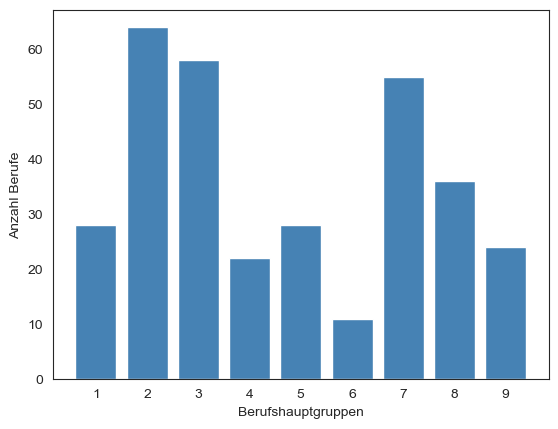

In [1234]:
# Get number per class and sort by index
freq = df['Berufshauptgruppe'].value_counts().sort_index()

# Create a bar chart
plt.bar(range(len(freq)), freq.values, color="#4682B4")

# Set title, x-label, y-label, and x-ticks
plt.ylabel('Anzahl Berufe', fontsize = 10)
plt.xlabel('Berufshauptgruppen', fontsize = 10)
plt.xticks(range(len(freq)), freq.index)

# Show the figure
plt.show()

In [1235]:
# Select only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Calculate correlation
corr = df_numeric.corr()

# Display the correlation matrix
corr

,s10,s1,s4,s11,s22,s6,s19,s18,s3,s15,...,a36,a39,a41,a43,a44,a28,a40,a49,fo_probability,fo_computerisation
s10,1.000000,0.770029,0.672323,0.764724,0.466438,0.759453,0.833295,0.487882,0.745445,0.740021,...,-0.264212,0.584499,-0.434502,-0.327394,0.625416,-0.465285,-0.335222,-0.356195,-0.615497,-0.566945
s1,0.770029,1.000000,0.655073,0.907829,0.486760,0.609810,0.732116,0.528739,0.849349,0.653809,...,-0.444883,0.544949,-0.561891,-0.471957,0.606383,-0.515339,-0.406269,-0.540124,-0.512661,-0.497289
s4,0.672323,0.655073,1.000000,0.673929,0.161483,0.586650,0.557283,0.785329,0.789313,0.797634,...,-0.395636,0.319915,-0.582951,-0.341665,0.322103,-0.557855,-0.476520,-0.470523,-0.540139,-0.508542
s11,0.764724,0.907829,0.673929,1.000000,0.473747,0.590353,0.729115,0.558942,0.826709,0.674505,...,-0.458201,0.508708,-0.598788,-0.452874,0.574143,-0.537627,-0.435714,-0.549215,-0.515446,-0.494409
s22,0.466438,0.486760,0.161483,0.473747,1.000000,0.343287,0.541619,0.094274,0.344726,0.164113,...,-0.068894,0.392832,0.017611,-0.147199,0.470962,-0.005614,-0.036301,-0.018745,-0.344085,-0.308931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a28,-0.465285,-0.515339,-0.557855,-0.537627,-0.005614,-0.288573,-0.386805,-0.446954,-0.548040,-0.604836,...,0.473488,-0.291044,0.850447,0.345633,-0.330256,1.000000,0.679940,0.678023,0.320121,0.329517
a40,-0.335222,-0.406269,-0.476520,-0.435714,-0.036301,-0.124780,-0.304406,-0.421662,-0.475494,-0.472033,...,0.497506,-0.162833,0.731116,0.401442,-0.215743,0.679940,1.000000,0.715187,0.302664,0.321625
a49,-0.356195,-0.540124,-0.470523,-0.549215,-0.018745,-0.179336,-0.348350,-0.457889,-0.524761,-0.508023,...,0.822362,-0.335856,0.872340,0.513452,-0.375562,0.678023,0.715187,1.000000,0.204038,0.239207
fo_probability,-0.615497,-0.512661,-0.540139,-0.515446,-0.344085,-0.534419,-0.551404,-0.431580,-0.563570,-0.531624,...,0.083767,-0.274323,0.285736,0.181165,-0.298342,0.320121,0.302664,0.204038,1.000000,0.950052


In [1236]:
cov = df_numeric.cov()
cov

,s10,s1,s4,s11,s22,s6,s19,s18,s3,s15,...,a36,a39,a41,a43,a44,a28,a40,a49,fo_probability,fo_computerisation
s10,145.042643,127.596451,95.821010,143.225842,113.283492,96.905201,141.946748,77.712487,107.662803,125.338046,...,-44.825408,95.080868,-116.967135,-28.458386,115.012761,-88.985106,-45.493988,-79.726343,-2.895440,-3.404700
s1,127.596451,189.307447,106.661633,194.248023,135.059047,88.894950,142.476432,96.217386,140.143181,126.510184,...,-86.229089,101.274790,-172.806418,-46.868145,127.397282,-112.597055,-62.989920,-138.115790,-2.755210,-3.411798
s4,95.821010,106.661633,140.045644,124.027447,38.537763,73.554960,93.280189,122.917810,112.017593,132.748391,...,-65.956149,51.136442,-154.202265,-29.182784,58.204832,-104.834979,-63.546126,-103.486116,-2.496783,-3.000906
s11,143.225842,194.248023,124.027447,241.845295,148.572940,97.270052,160.377584,114.964644,154.178499,147.517829,...,-100.380368,106.856008,-208.144851,-50.832053,136.338452,-132.770118,-76.356055,-158.736791,-3.131071,-3.833941
s22,113.283492,135.059047,38.537763,148.572940,406.676593,73.346597,154.488863,25.144578,83.368155,46.543407,...,-19.571817,107.002246,7.938263,-21.424955,145.024115,-1.797791,-8.249363,-7.025304,-2.710386,-3.106541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a28,-88.985106,-112.597055,-104.834979,-132.770118,-1.797791,-48.551713,-86.880264,-93.873242,-104.367400,-135.076055,...,105.921378,-62.426711,301.870864,39.614667,-80.081227,252.173893,121.672883,200.106409,1.985659,2.609269
a40,-45.493988,-62.989920,-63.546126,-76.356055,-8.249363,-14.897669,-48.518301,-62.844323,-64.257046,-74.806022,...,78.976196,-24.784332,184.154998,32.650326,-37.122662,121.672883,126.983332,149.781878,1.332217,1.807230
a49,-79.726343,-138.115790,-103.486116,-158.736791,-7.025304,-35.312789,-91.571581,-112.552430,-116.958112,-132.782388,...,215.304672,-84.310392,362.389740,68.874280,-106.580472,200.106409,149.781878,345.408145,1.481217,2.216819
fo_probability,-2.895440,-2.755210,-2.496783,-3.131071,-2.710386,-2.211673,-3.046420,-2.229617,-2.639922,-2.920362,...,0.460932,-1.447322,2.494765,0.510747,-1.779443,1.985659,1.332217,1.481217,0.152574,0.185046


<Axes: xlabel='fo_probability'>

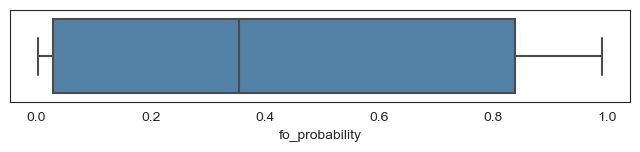

In [1237]:
# boxplot of probabilities of computerisation
plt.figure(figsize=(8,1.2))
sns.set_style("white")
sns.boxplot(x=df['fo_probability'], color="#4682B4")

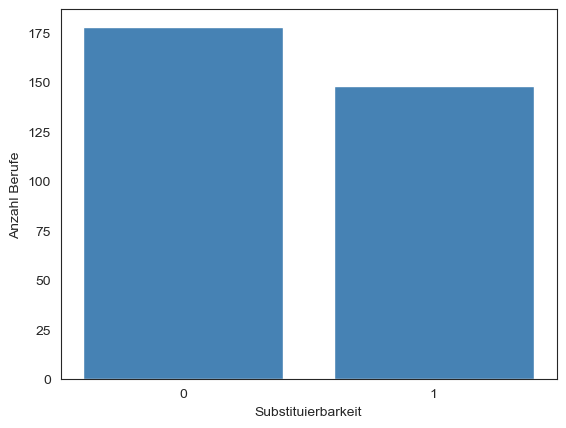

In [1238]:
# Get number per class
freq = df['fo_computerisation'].value_counts()

# Create a bar chart
plt.bar(freq.index, freq.values, color="#4682B4")
# plt.title('Substituierbarkeit nach Osborne & Frey (2013)')
plt.ylabel('Anzahl Berufe', fontsize = 10)
plt.xticks(freq.index)
plt.xlabel('Substituierbarkeit', fontsize = 10)
plt.show()

## Downsampling, Upsampling, SMOTE

In [1239]:
df_numeric = df.drop(columns=['isco08', 'Name_de'])

In [1240]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_numeric.drop('fo_computerisation', axis=1), df_numeric['fo_computerisation'], test_size=0.2, random_state=100)

# Fit a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.2f' % auc)

AUC: 0.85


/opt/anaconda3/envs/bachelorarbeit/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### calculate minority and majority class automaitcally

In [1241]:
# Get the counts of each class
class_counts = df_numeric['fo_computerisation'].value_counts()

# Identify majority and minority classes
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Separate majority and minority classes
df_majority = df_numeric[df['fo_computerisation'] == majority_class]
df_minority = df_numeric[df['fo_computerisation'] == minority_class]

### SMOTE

In [1242]:
# Assuming your dataframe is df and 'fo_computerisation' is the target column
X = df_numeric.select_dtypes(include=[np.number]).drop('fo_computerisation', axis=1)
y = df_numeric['fo_computerisation']

oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

counter = Counter(y)
print(counter)

df_smote = pd.concat([pd.DataFrame(X), pd.DataFrame(y, columns=['fo_computerisation'])], axis=1)

Counter({0: 178, 1: 178})


In [1243]:
# calculate "fo_computerisation" based on 'df_probability' to make sure SMOTE didn't mess this up
df_smote['fo_computerisation'] = df_smote['fo_probability'].apply(lambda x: 1 if x >= 0.5 else 0)

In [1244]:
# Get Amount per class
freq = df_smote['fo_computerisation'].value_counts()
print(freq)

fo_computerisation
0    178
1    178
Name: count, dtype: int64


In [1245]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_smote.drop('fo_computerisation', axis=1), df_smote['fo_computerisation'], test_size=0.2, random_state=56)

# Fit a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.2f' % auc)

AUC: 0.89


/opt/anaconda3/envs/bachelorarbeit/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Upsampling

In [1246]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=53) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.fo_computerisation.value_counts()

fo_computerisation
0    178
1    178
Name: count, dtype: int64

In [1247]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_upsampled.drop('fo_computerisation', axis=1), df_upsampled['fo_computerisation'], test_size=0.2, random_state=100)

# Fit a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.2f' % auc)

AUC: 0.89


/opt/anaconda3/envs/bachelorarbeit/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Downsampling

In [1248]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=df_minority.shape[0],  # to match minority class
                                   random_state=42) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled.fo_computerisation.value_counts()

fo_computerisation
0    148
1    148
Name: count, dtype: int64

In [1249]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_downsampled.drop('fo_computerisation', axis=1), df_downsampled['fo_computerisation'], test_size=0.2, random_state=53)

# Fit a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.2f' % auc)

AUC: 0.78


/opt/anaconda3/envs/bachelorarbeit/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## weitere Darstellungen

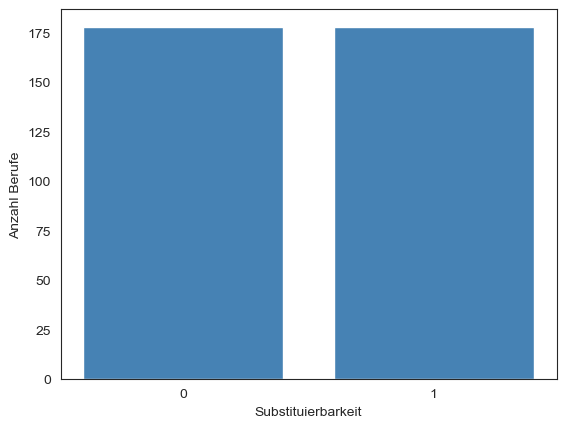

In [1250]:
# Get number per class
freq = df_smote['fo_computerisation'].value_counts()

# Create a bar chart
plt.bar(freq.index, freq.values, color="#4682B4")
# plt.title('Substituierbarkeit nach Osborne & Frey (2013)')
plt.ylabel('Anzahl Berufe', fontsize = 10)
plt.xticks(freq.index)
plt.xlabel('Substituierbarkeit', fontsize = 10)
plt.show()

<Axes: xlabel='fo_probability'>

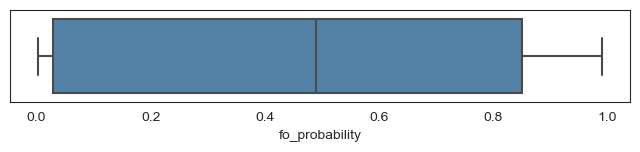

In [1251]:
# boxplot of probabilities of computerisation
plt.figure(figsize=(8,1.2))
sns.set_style("white")
sns.boxplot(x=df_smote['fo_probability'], color="#4682B4")

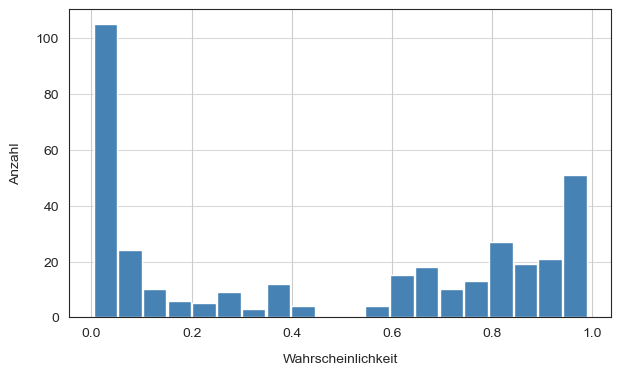

In [1252]:
# Plot Histogram
fig = plt.figure( figsize=(7,4))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
n, bins, patches = plt.hist(x=df_smote['fo_probability'], 
                            bins=20, 
                            color="#4682B4",
                            rwidth=0.95
                   )
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.grid(axis='y', alpha=0.75)

# Set labels
plt.xlabel('Wahrscheinlichkeit', fontsize=10, labelpad=10)
plt.ylabel('Anzahl', fontsize=10, labelpad=10)
# plt.title('Histogram of probability of computerisation', fontsize=12, pad=10)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

/opt/anaconda3/envs/bachelorarbeit/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(5.569444444444445, 0.5, 'Density')

<Figure size 700x400 with 0 Axes>

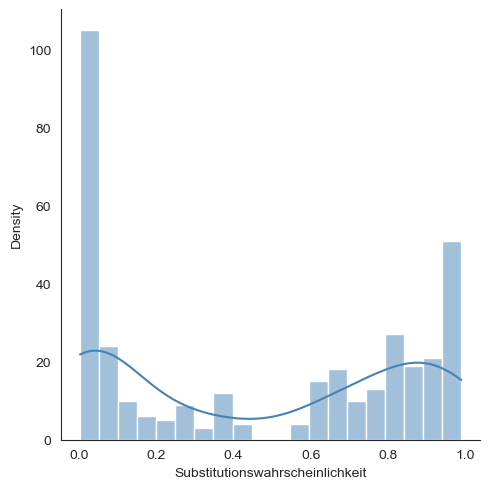

In [1253]:
fig = plt.figure(figsize=(7,4))
sns.displot(df_smote['fo_probability'], bins=20, color="#4682B4", kde=True)
# plt.title('Density plot computerisation probability', fontsize=12)
plt.xlabel('Substitutionswahrscheinlichkeit', fontsize=10)
plt.ylabel('Density', fontsize=10)

## Regressionskoeffizienten und Konfidenzintervalle berechnen

Optimization terminated successfully.
         Current function value: 0.319861
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         fo_probability   No. Observations:                  356
Model:                          Logit   Df Residuals:                      268
Method:                           MLE   Df Model:                           87
Date:                Sat, 18 May 2024   Pseudo R-squ.:                  0.5354
Time:                        14:25:29   Log-Likelihood:                -113.87
converged:                       True   LL-Null:                       -245.12
Covariance Type:            nonrobust   LLR p-value:                 1.671e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3099      3.827      2.172      0.030       0.810      15.810
s10           -0.0500      0.

/var/folders/ms/0wqr6tr506lfp142wmz0qph40000gn/T/ipykernel_5012/3409149365.py:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axhspan(-0.01, 0.01, color='#ff0000', alpha=0.3, edgecolor='none')
/var/folders/ms/0wqr6tr506lfp142wmz0qph40000gn/T/ipykernel_5012/3409149365.py:38: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axhspan(0.011, 0.05, color='#00FF00', alpha=0.1, edgecolor='none')
/var/folders/ms/0wqr6tr506lfp142wmz0qph40000gn/T/ipykernel_5012/3409149365.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axhspan(-0.05, -0.011, color='#00FF00', alpha=0.1, edgecolor='none')


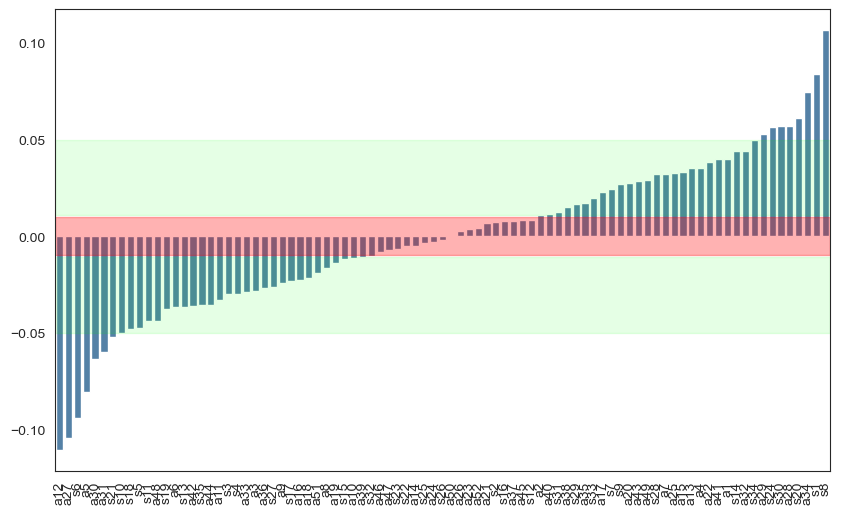

In [1254]:

# Select columns that start with 's' or 'a' and the 'fo_probability' column
df_selected = df_smote.filter(regex='^(s|a|fo_probability)')

# Define the dependent variable
y = df_selected['fo_probability']

# Define the independent variables
X = df_selected.drop('fo_probability', axis=1)

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Fit the model
model = sm.Logit(y, X)
results = model.fit()

# Print the summary statistics
print(results.summary())

# Get the regression coefficients
coefficients = results.params

# Drop the constant
coefficients = coefficients.drop('const')

# Sort the coefficients
coefficients = coefficients.sort_values()

# Create a bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=coefficients.index, y=coefficients.values, color="#4682B4")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Konfidenzintervall 99%
plt.axhspan(-0.01, 0.01, color='#ff0000', alpha=0.3, edgecolor='none')

# Konfidenzintervall 95%
plt.axhspan(0.011, 0.05, color='#00FF00', alpha=0.1, edgecolor='none')
plt.axhspan(-0.05, -0.011, color='#00FF00', alpha=0.1, edgecolor='none')

plt.show()

In [1255]:
# Extract coefficients outside the 95% confidence interval
coefficients_outside_95 = coefficients[(coefficients < -0.05) | (coefficients > 0.05)].round(4)

# Extract coefficients outside the 99% confidence interval
coefficients_outside_99 = coefficients[(coefficients < -0.01) | (coefficients > 0.01)].round(4)

In [1256]:
# Create a dataframe from the coefficients outside the 95% and 99% confidence intervals with headers
coefficients_outside_95 = pd.DataFrame(list(coefficients_outside_95.items()), columns=['id', 'coefficient'])
coefficients_outside_99 = pd.DataFrame(list(coefficients_outside_99.items()), columns=['id', 'coefficient'])

# Merge skills dataframe with coefficients
coefficients_outside_95 = coefficients_outside_95.merge(skills, left_on='id', right_on='skill_id', how='left')
coefficients_outside_99 = coefficients_outside_99.merge(skills, left_on='id', right_on='skill_id', how='left')

# Merge abilities dataframe with coefficients
coefficients_outside_95 = coefficients_outside_95.merge(abilities, left_on='id', right_on='ability_id', how='left')
coefficients_outside_99 = coefficients_outside_99.merge(abilities, left_on='id', right_on='ability_id', how='left')

# remove unnecessary columns
coefficients_outside_95 = coefficients_outside_95.drop(columns=['skill_id', 'ability_id'])
coefficients_outside_99 = coefficients_outside_99.drop(columns=['skill_id', 'ability_id'])

In [1257]:
# Merge skill and skill description
coefficients_outside_95['skill'] = coefficients_outside_95['skill'].fillna(coefficients_outside_95['ability'])
coefficients_outside_95["skill_description"] = coefficients_outside_95["skill_description"].fillna(coefficients_outside_95["ability_description"])

coefficients_outside_99['skill'] = coefficients_outside_99['skill'].fillna(coefficients_outside_99['ability'])
coefficients_outside_99["skill_description"] = coefficients_outside_99["skill_description"].fillna(coefficients_outside_99["ability_description"])

# Now you can drop the abilities
coefficients_outside_95 = coefficients_outside_95.drop(columns=['ability_description', 'ability'])
coefficients_outside_99 = coefficients_outside_99.drop(columns=['ability_description', 'ability'])

In [1258]:
# Save the dataframes to csv files
coefficients_outside_95.reset_index().rename(columns={'index': 'Variable', 0: 'Coefficient'}).sort_values('coefficient').drop(columns=["Variable"]).to_csv('files/coefficients_outside_95.csv', index=False)
coefficients_outside_99.reset_index().rename(columns={'index': 'Variable', 0: 'Coefficient'}).sort_values('coefficient').drop(columns=["Variable"]).to_csv('files/coefficients_outside_99.csv', index=False)

In [1259]:
# Get the column names that are not in coefficients_outside_95["id"] and start with 's' or 'a'
cols_to_zero = [col for col in df_smote.columns if (col not in coefficients_outside_95["id"].values) and (col.startswith('s') or col.startswith('a'))]

# add ids that were removed manually
cols_to_zero.extend(["a27","s6","a5","a30","a31","a29","s30","a28","s20","a34","s1"])

In [1260]:
# Drop these columns
df_smote = df_smote.drop(columns=cols_to_zero)

# Display the first few rows of the DataFrame
df_smote.head(5)

,s24,s21,s8,a12,fo_probability,fo_computerisation
0,6,19,47,47,0.370,0
1,19,22,72,78,0.400,0
2,28,44,63,72,0.240,0
3,22,50,75,75,0.035,0
4,19,44,63,72,0.015,0


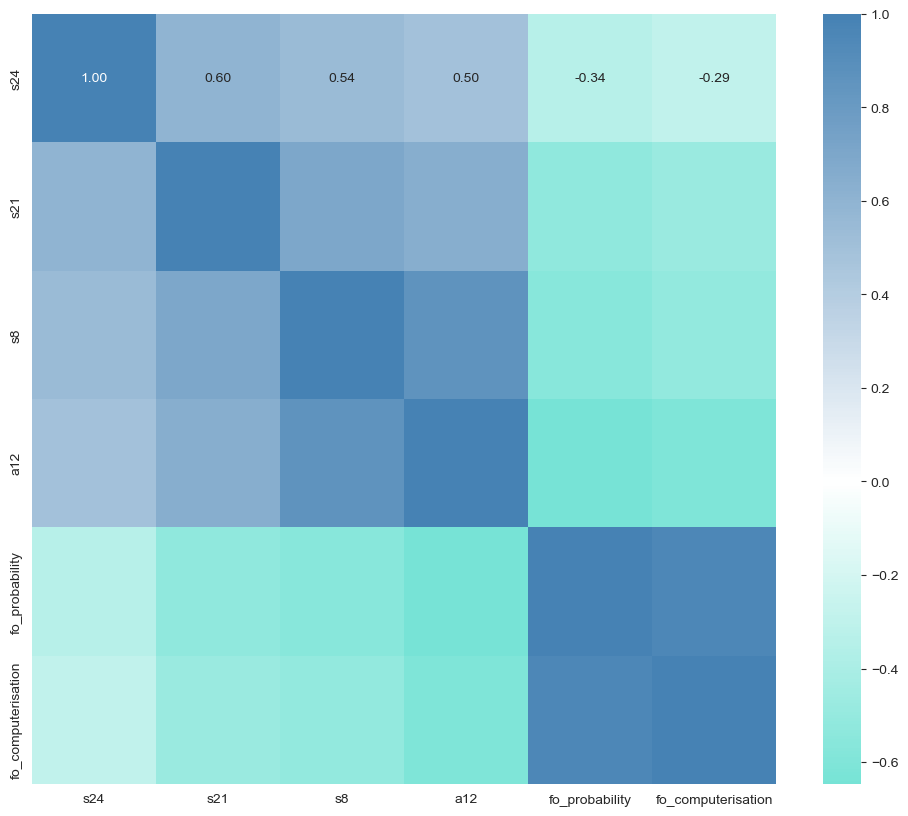

In [1261]:
# Calculate the correlation matrix
corr_matrix = df_smote.corr()

# Create a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["#2dd4bf", "white", "#4682B4"])

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, center=0)

# Show the plot
plt.show()

In [1262]:
coefficients_outside_95.head(4)

,id,coefficient,skill,skill_description
0,a12,-0.1107,Deductive Reasoning,The ability to apply general rules to specific...
1,a27,-0.1043,Extent Flexibility,"The ability to bend, stretch, twist, or reach ..."
2,s6,-0.0943,Monitoring,"Monitoring/Assessing performance of yourself, ..."
3,a5,-0.0807,Written Comprehension,The ability to read and understand information...


In [1263]:
# Extract coefficients outside the 95% confidence interval
selected_coefficients = coefficients_outside_95[["id","coefficient"]]

In [1276]:
#
coef_dict = selected_coefficients.set_index('id')['coefficient'].to_dict()

for col in df_smote.columns:
    if col.startswith(('a', 's')):
        df_smote[f'weight_{col}'] = coef_dict.get(col, 1)
        
print("Keys in coef_dict:", coef_dict.keys())

relevant_cols = [col for col in df_smote.columns if col.startswith(('a', 's'))]
print("Relevant columns in df_calculate_automation:", relevant_cols)

df_smote.head(5)

Keys in coef_dict: dict_keys(['a12', 'a27', 's6', 'a5', 'a30', 'a31', 's21', 'a29', 's24', 's30', 'a28', 's20', 'a34', 's1', 's8'])
Relevant columns in df_calculate_automation: ['s24', 's21', 's8', 'a12', 'automation_probability']


,s24,s21,s8,a12,fo_probability,fo_computerisation,weight_s24,weight_s21,weight_s8,weight_a12,weighted_sum,automation_probability,weight_automation_probability
0,6,19,47,47,0.370,0,0.0564,-0.052,0.1067,-0.1107,120.0,1.0,1
1,19,22,72,78,0.400,0,0.0564,-0.052,0.1067,-0.1107,192.0,1.0,1
2,28,44,63,72,0.240,0,0.0564,-0.052,0.1067,-0.1107,208.0,1.0,1
3,22,50,75,75,0.035,0,0.0564,-0.052,0.1067,-0.1107,223.0,1.0,1
4,19,44,63,72,0.015,0,0.0564,-0.052,0.1067,-0.1107,199.0,1.0,1


In [1277]:
weighted_cols = [col for col in df_smote.columns if col.startswith(('a', 's'))]

df_smote['weighted_sum'] = 0

for col in weighted_cols:
    df_smote['weighted_sum'] += df_smote[col] * df_smote[f'weight_{col}']
    
df_smote.head(5)

,s24,s21,s8,a12,fo_probability,fo_computerisation,weight_s24,weight_s21,weight_s8,weight_a12,weighted_sum,automation_probability,weight_automation_probability
0,6,19,47,47,0.370,0,0.0564,-0.052,0.1067,-0.1107,0.1624,1.0,1
1,19,22,72,78,0.400,0,0.0564,-0.052,0.1067,-0.1107,-0.0246,1.0,1
2,28,44,63,72,0.240,0,0.0564,-0.052,0.1067,-0.1107,-0.9571,1.0,1
3,22,50,75,75,0.035,0,0.0564,-0.052,0.1067,-0.1107,-0.6592,1.0,1
4,19,44,63,72,0.015,0,0.0564,-0.052,0.1067,-0.1107,-1.4647,1.0,1


In [1278]:
df_smote['automation_probability'] = df_smote['weighted_sum'].apply(lambda x: 1 / (1 + np.exp(-x)))

In [1279]:
df_smote.nlargest(5, 'automation_probability')

,s24,s21,s8,a12,fo_probability,fo_computerisation,weight_s24,weight_s21,weight_s8,weight_a12,weighted_sum,automation_probability,weight_automation_probability
222,22,0,50,50,0.940,1,0.0564,-0.052,0.1067,-0.1107,2.0408,0.885015,1
201,22,0,50,53,0.710,1,0.0564,-0.052,0.1067,-0.1107,1.7087,0.846668,1
218,16,3,50,50,0.870,1,0.0564,-0.052,0.1067,-0.1107,1.5464,0.824393,1
45,13,0,50,50,0.770,1,0.0564,-0.052,0.1067,-0.1107,1.5332,0.822474,1
103,25,28,60,53,0.003,0,0.0564,-0.052,0.1067,-0.1107,1.4889,0.815913,1


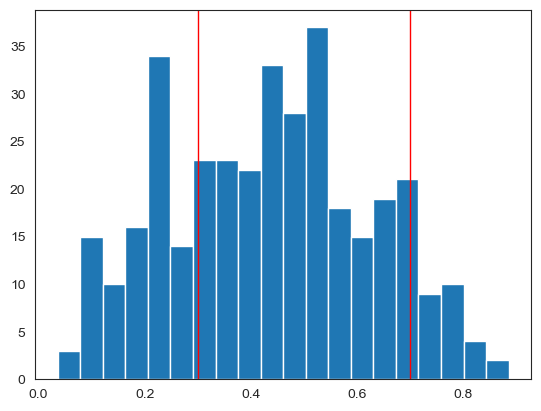

In [1280]:
# Get the values
x = df_smote["automation_probability"].values

# Calculate the histogram
hist, bins = np.histogram(x, bins=20)

# Calculate the width and center of the bars
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# Plot the histogram
plt.bar(center, hist, align='center', width=width)

# Add lines at 0.3 and 0.7
plt.axvline(0.3, color='r', linewidth=1)
plt.axvline(0.7, color='r', linewidth=1)

# Show the plot
plt.show()